# 2018-09-24 Dynamic theta rotation
Modyfing the input angle as the stim goes and check out what's happening
Plus I moved the ring into a py file

In [1]:
import Ring

/home/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.6/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DictError in SLIInterpreter::execute: Key '/Install' does not exist in dictionary.
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


But since this is about changing stim params i'm still keeping all the mess inside this notebook

In [2]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
import numpy as np

In [3]:
class Net_Parameters :
    def __init__(self, ring=True, recurrent=False, seed=42, source='poisson'):
        self.seed = seed
        self.source = source
        self.recurrent = recurrent
        self.ring = ring


        #c : connectivity probability
        #w : global weight, value for every connections
        #i_rate : input rate, mean firing rate of source population neurons
        #w_in : weight of connections between source population and excitatory neurons population
        #s : synaptic delay
        #g : inhibition-excitation coupling
        #p : excitatory neurons percentage in network
        #n_model : neuron dynamic model
        #b_input : input orientation distribution bandwidth
        #angle_input : the most represented orientation angle in input distribution
        #b_xx : orientation selectivity for a projection xx
        '''
        Parameters : Network parameters, Neuron parameters, Simulation parameters,
        '''
        #a.General network params
        #Ring network
        if self.ring:
            self.c = 1.
            if self.recurrent :
                self.w, self.w_inh, w_input_exc = .2, .3, .3
                self.g = 3.
            else:
                self.w, self.w_inh, w_input_exc = .1, .0, .3
                self.g = 0.
        #Non ring network
        else:
            self.c = 0.15
            if self.recurrent :
                self.w, self.w_inh, w_input_exc = .25, .2, .3
                self.g = 1.
            else:
                self.w, self.w_inh, w_input_exc = .0, .0, .3
                self.g = 0.
                
        #b.Point neuron params        
        self.cell_params = {
        'tau_m'      : 20.0,   # (ms)
        'tau_syn_E'  : 2.0,    # (ms)
        'tau_syn_I'  : 4.0,    # (ms)
        'e_rev_E'    : 0.0,    # (mV)
        'e_rev_I'    : -70.0,  # (mV)
        'tau_refrac' : 2.0,    # (ms)
        'v_rest'     : -60.0,  # (mV)
        'v_reset'    : -70.0,  # (mV)
        'v_thresh'   : -50.0,  # (mV)
        'cm'         : 0.5,    # (nF)
        }
        
        #c.Simulation params
        self.sim_params = {
        'simtime'     : 1000,   #(ms)
        'input_rate'  : 10.,   #(Hz)
        'b_input'     : np.inf,#infinite
        'angle_input' : 90,    #degrees
            
        #params for the angles shifts
        'nb_shifts' : 6, #number of time the angles are shifting, as in next call at t + simtime/nb_shifts
        'mag_shifts' : 100, #magnitude of the shift, as in angle = t/magshift * (regular angle formula)

        'nb_neurons'  : 1000,  #neurons number
        'p'           : .5,        #excitatory rate in the population
        'neuron_model': 'IF_cond_exp',    #point neuron model
        'v_init_min'   : -53.5,  # (mV)
        'v_init_max'   : -49.75,  # (mV)

        #'c_input_exc' : 1., #self.c*10,
        'c_input_inh' : 0, #self.c*0.,
        'w_input_exc' : w_input_exc,
        
        #delays in ms
        's_input_exc' : 1,
        's_input_inh' : 1,
        's_exc_inh'   : 1,
        's_inh_exc'   : 1,
        's_exc_exc'   : 1,
        's_inh_inh'   : 1,
            
        #B_thetas for the ring ?
        'b_exc_inh'   : np.inf,
        'b_exc_exc'   : np.inf,
        'b_inh_exc'   : np.inf,
        'b_inh_inh'   : np.inf,
        
        #connectivity patterns
        'c_exc_inh'   : self.c,
        'c_inh_exc'   : self.c,
        'c_exc_exc'   : self.c,
        'c_inh_inh'   : self.c,

        #synaptic weight (µS)
        'w_exc_inh'   : self.w*self.g,
        'w_inh_exc'   : self.w_inh,
        'w_exc_exc'   : self.w,
        'w_inh_inh'   : self.w_inh*self.g,
        }
        
        #optimized params for ring
        if self.ring :
            self.sim_params['b_input'] = 10.
            self.sim_params['b_exc_inh'] = 5.
            self.sim_params['b_exc_exc'] = 10.
            self.sim_params['b_inh_exc'] = 40.
            self.sim_params['b_inh_inh'] = 10.
            
#    def return_params(self):
#        return (self.sim_params)

In [4]:
from joblib import Parallel, delayed

class RNN_Simulation:
    def __init__(self, sim_params=None, cell_params=None, verbose = True):
        '''
        Parameters : Stimulus, Population, Synapses, Recording, Running 
        '''
        self.verbose = verbose
        self.sim_params = sim_params
        self.cell_params = cell_params
        
        sim.setup(spike_precision = 'on_grid')#spike_precision='on_grid')#timestep = .1)
        
        N_in = int(sim_params['nb_neurons']*sim_params['p']) #total pop * proportion of inhib
        prog_rate = sim_params['input_rate']
        self.spike_source = sim.Population(N_in, sim.SpikeSourcePoisson(rate=prog_rate,
                                                                        duration=sim_params['simtime']))
        
        #orientation stimulus, see bottom section of notebook
        angle = 1. * np.arange(N_in)
        rates = self.tuning_function(angle, sim_params['angle_input']/180.*N_in, sim_params['b_input'], N_in)
        rates /= rates.mean()
        rates *= sim_params['input_rate']
        for i, cell in enumerate(self.spike_source):
            cell.set_parameters(rate=rates[i])
        
        #neuron model selection
        if sim_params['neuron_model'] == 'IF_cond_alpha':
            model = sim.IF_cond_alpha #LIF with nice dynamics
        else: 
            model = sim.IF_cond_exp #LIF with exp dynamics
        
        #populations, reminder that E_neurons is the same size as the spike source(N_in)
        E_neurons = sim.Population(N_in, 
                                   model(**cell_params),
                                   initial_values={'v': rnd('uniform', (sim_params['v_init_min'], sim_params['v_init_max']))},
                                   label="Excitateurs")
        I_neurons = sim.Population(int(sim_params['nb_neurons'] - N_in),
                                   model(**cell_params),
                                   initial_values={'v': rnd('uniform', (sim_params['v_init_min'], sim_params['v_init_max']))},
                                   label="Inhibiteurs")
        
        #input to excitatories
        self.input_exc = sim.Projection(self.spike_source, E_neurons,
                                sim.OneToOneConnector(),
                                sim.StaticSynapse(weight=sim_params['w_input_exc'], delay=sim_params['s_input_exc'])
                                )
        
        #loop through connections type and use associated params, can be a bit slow
        conn_types = ['exc_inh', 'inh_exc', 'exc_exc', 'inh_inh']   #connection types
        '''
        self.proj = self.set_synapses(conn_types = conn_types, sim_params =sim_params, 
                                      E_neurons = E_neurons, I_neurons = I_neurons, 
                                      N_inh = N_inh)
        '''
        #Multi threading support NE MARCHE PAS LAISSER LE NJOBS EN 1
        self.proj = Parallel(n_jobs =1, backend = 'multiprocessing')(delayed(self.set_synapses)(conn_type,sim_params =sim_params, 
                                      E_neurons = E_neurons, I_neurons = I_neurons, 
                                      N_in = N_in, conn_types = conn_types) for conn_type in range(len(conn_types)))
        if verbose :print('Done building synapses !')
            
        #record
        self.spike_source.record('spikes')
        E_neurons.record('spikes')
        I_neurons.record('spikes')
        
        #run
        if verbose : print('Running simulation..')
        self.shift_times = [] #a list of shift times with append done in vary_angle
        sim.run_until(sim_params['simtime'], callbacks=[self.vary_angle])
        if verbose : print('Done running !')
        
        #get the spikes
        self.E_neurons = E_neurons#.get_data().segments[0]
        self.I_neurons = I_neurons#.get_data().segments[0]
        self.P_neurons = self.spike_source#.get_data().segments[0]
    
    #run callback function that changes the input angle every 
    def vary_angle(self, t):
        #wanky trick that allows me to leave N_in as a non-self var
        N_in = int(self.sim_params['nb_neurons']*self.sim_params['p']) 
        arg_rates = (t/self.sim_params['mag_shifts'])*self.sim_params['angle_input']/180.*N_in
        
        angle = 1. * np.arange(N_in)
        rates = self.tuning_function(angle,arg_rates,self.sim_params['b_input'], N_in)
        rates /= rates.mean()
        rates *= self.sim_params['input_rate']
        for i, cell in enumerate(self.spike_source):
            cell.set_parameters(rate=rates[i])
            
        if self.verbose : print('At sim time %s ,current maximum angle %s' % (t, arg_rates ))
        self.shift_times.append(t)
        return t + int(self.sim_params['simtime']/self.sim_params['nb_shifts'])

    def set_synapses(self, conn_type, sim_params, E_neurons, I_neurons, N_in, conn_types):
        syn = {}
        proj = {}

        if self.verbose : print('Building %s synapses..' % conn_types[conn_type])
        weight = sim_params['w_{}'.format(conn_types[conn_type])]
        delay=sim_params['s_{}'.format(conn_types[conn_type])]
        syn[conn_types[conn_type]] = sim.StaticSynapse(delay=delay)

        if conn_types[conn_type][:3]=='exc': #string slicing, this co is FROM exc
            pre_neurons = E_neurons
            receptor_type='excitatory'
        else:
            pre_neurons = I_neurons #FROM inh
            receptor_type='inhibitory'
        if conn_types[conn_type][-3:]=='exc': #To exc
            post_neurons = E_neurons
        else:
            post_neurons = I_neurons #To inh

        sparseness = sim_params['c_{}'.format(conn_types[conn_type])]
        proj[conn_types[conn_type]]  = sim.Projection(pre_neurons, post_neurons,
                                        connector=sim.FixedProbabilityConnector(sparseness, rng=sim.NumpyRNG(seed=42)),
                                        synapse_type=syn[conn_types[conn_type]],
                                        receptor_type=receptor_type)
        bw = sim_params['b_{}'.format(conn_types[conn_type])]
        angle_pre = 1. * np.arange(proj[conn_types[conn_type]].pre.size)
        angle_post = 1. * np.arange(proj[conn_types[conn_type]].post.size)
        w_ij = self.tuning_function(angle_pre[:, np.newaxis], angle_post[np.newaxis, :], bw, N_in)*weight
        proj[conn_types[conn_type]].set(weight=w_ij)
        
        return proj
        
    def tuning_function(self, i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM

In [5]:
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt

class PlotTwist:
    def __init__(self, sim_params = None, cell_params = None, verbose = True):
        self.verbose = verbose
        self.sim_params = sim_params
        self.cell_params = cell_params
        
    #RasterPlot using  pyNN    
    def RasterPlot(self, SpikesP, SpikesE, SpikesI, title = 'Title', markersize = .5):
        fig = Figure(
            Panel(SpikesP.spiketrains, xticks = False, ylabel = 'Input', color = 'k', markersize = markersize),
            Panel(SpikesE.spiketrains, xticks = False, ylabel = 'Excitatory', color = 'r', markersize = markersize),
            Panel(SpikesI.spiketrains, xticks = True, xlabel = 'Time(ms)', ylabel = 'Inhibitory',
                  color = 'b', markersize = markersize),
            title = title, settings = {'figure.figsize': [9., 6.]})
        
        '''for ax in fig.fig.axes:
            ax.set_xticks(np.linspace(0, self.sim_params['simtime'], 6, endpoint = True))'''
        fig.fig.subplots_adjust(hspace = 0)
        return fig
    
    def VanillaRasterPlot(self, SpikesP, SpikesE, SpikesI, title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
            
        fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = figsize)
        plot_spiketrains(axs[0], SpikesP, color = 'k', ylabel = 'Neuron Index', do_ticks = False)
        axs[0].set_title('Poisson input')
        plot_spiketrains(axs[1], SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs[1].set_title('Inhibitory population')
        plot_spiketrains(axs[2], SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs[2].set_title('Excitatory population')
        plt.xlabel('Time(ms)')
        
    #TODO finish this method
    def OneParamVar_RasterPlot(self, spikesP, spikesE, spikesI, title = 'Title', markersize = .5,
                              var_name = None, var_values = None, force_int = False):
        '''
        var_name is the variable name as it is in sim_param (otherwise it won't work)
        '''
        if force_int : values = [int(i) for i in values]
        
        for i, value in enumerate(var_values):
            sim_params[var_name] = value
            self.RasterPlot(SpikesP, SpikesE, SpikesI, title = 'Variable %s : %s' %(var_name, value))

# Un exemple de réseau qui suit (avec des params pas biologiques)

In [13]:
import time
now = time.time()
params = Net_Parameters(ring = True, recurrent = True)
params.sim_params.update({'nb_neurons' : 100,
                          'nb_shifts' : 6,
                         'p' : .5})
RNN = RNN_Simulation(sim_params = params.sim_params, cell_params = params.cell_params, verbose = True)
#plotter = PlotTwist()
then = time.time()
print('Time elapsed : %s' % (then-now))

Building exc_inh synapses..
Building inh_exc synapses..
Building exc_exc synapses..
Building inh_inh synapses..
Done building synapses !
Running simulation..
At sim time 0.0 ,current maximum angle 0.0
At sim time 166.0 ,current maximum angle 41.5
At sim time 332.0 ,current maximum angle 83.0
At sim time 498.0 ,current maximum angle 124.50000000000001
At sim time 664.0 ,current maximum angle 166.0
At sim time 830.0 ,current maximum angle 207.50000000000003
At sim time 996.0 ,current maximum angle 249.00000000000003
At sim time 1000.0 ,current maximum angle 250.0
Done running !
Time elapsed : 6.181971549987793


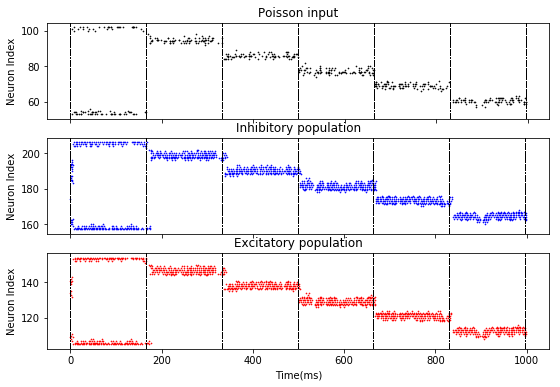

In [14]:
#Plotting time
E = RNN.E_neurons.get_data().segments[0]
I = RNN.I_neurons.get_data().segments[0]
P = RNN.P_neurons.get_data().segments[0]
plotter = PlotTwist()
plotter.VanillaRasterPlot(SpikesP = P, SpikesE = E, SpikesI = I,
                          markersize = .4, figsize = (9,6), shifts = RNN.shift_times[0:-1])

# Un exemple de réseau qui suit pas, mais dont le ratio E/I est plus réel
Voir https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3325497/

In [10]:
import time
now = time.time()
params = Net_Parameters(ring = True, recurrent = True)
params.sim_params.update({'nb_neurons' : 100,
                          'nb_shifts' : 6,
                          'mag_shifts' : 105,
                         'p' : .8})
RNN = RNN_Simulation(sim_params = params.sim_params, cell_params = params.cell_params, verbose = True)
#plotter = PlotTwist()
then = time.time()
print('Time elapsed : %s' % (then-now))

Building exc_inh synapses..
Building inh_exc synapses..
Building exc_exc synapses..
Building inh_inh synapses..
Done building synapses !
Running simulation..
At sim time 0.0 ,current maximum angle 0.0
At sim time 166.0 ,current maximum angle 63.238095238095234
At sim time 332.0 ,current maximum angle 126.47619047619047
At sim time 498.0 ,current maximum angle 189.71428571428572
At sim time 664.0 ,current maximum angle 252.95238095238093
At sim time 830.0 ,current maximum angle 316.1904761904762
At sim time 996.0 ,current maximum angle 379.42857142857144
At sim time 1000.0 ,current maximum angle 380.95238095238096
Done running !
Time elapsed : 6.514180898666382


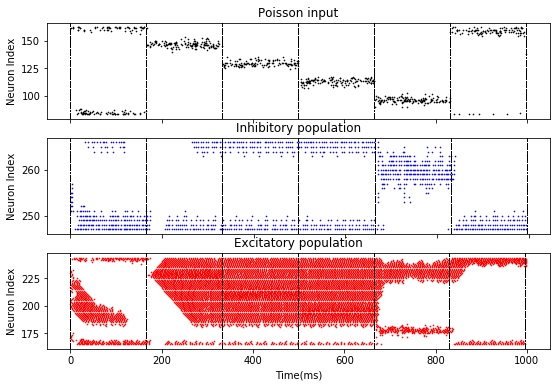

In [11]:
E = RNN.E_neurons.get_data().segments[0]
I = RNN.I_neurons.get_data().segments[0]
P = RNN.P_neurons.get_data().segments[0]
plotter = PlotTwist()
plotter.VanillaRasterPlot(SpikesP = P, SpikesE = E, SpikesI = I,
                          markersize = .4, figsize = (9,6), shifts = RNN.shift_times[0:-1])